In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import os
from datetime import datetime

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)

!rm -rf ./logs/ 

# Image Classifciation (with data augmentation)

Lets build a Convolutional Nerual Network for classifying images, and then use *data augmentation* and dropout to improve regularisation and reduce overfitting.

In [2]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Lets use the [dogs versus cats dataset](https://www.kaggle.com/c/dogs-vs-cats/data) from Kaggle. Which contains images of dogs and cats, where we want to classify the output as either $1=dog, 0=cat$.

In [3]:
# Load the dataset
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Meta data about the dataset
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))
num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("==")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
==
Total training images: 2000
Total validation images: 1000


We can see that we don't have that much training images to work with to train our convolutional neural network. We will first attempt to train a network with the current dataset, and artificially augment the training samples to generate more samples some of which will be augmented versions of the original training samples to generate a larger set of training samples to train our model from.

We can use the `tf.keras.preprocessing.image.ImageDataGenerator` class to generate batches of tensor image data with real-time data augmentation. This can also allow us to read the images from disk, decode the image format into RGB floating point tensors and rescale the values from 0 and 255 to those between 0 and 1 (as neural networks perform best on small input values). We can use its `flow_from_directory` method to load images from the disk, rescale and resize the images to the required dimensions specified.

In [42]:
batch_size = 32
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(
                                                               IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [5]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


We can visualize the a few of the training images, by returning the next batch form the dataset generator, where the output is of the form `(X_train, y_train)`

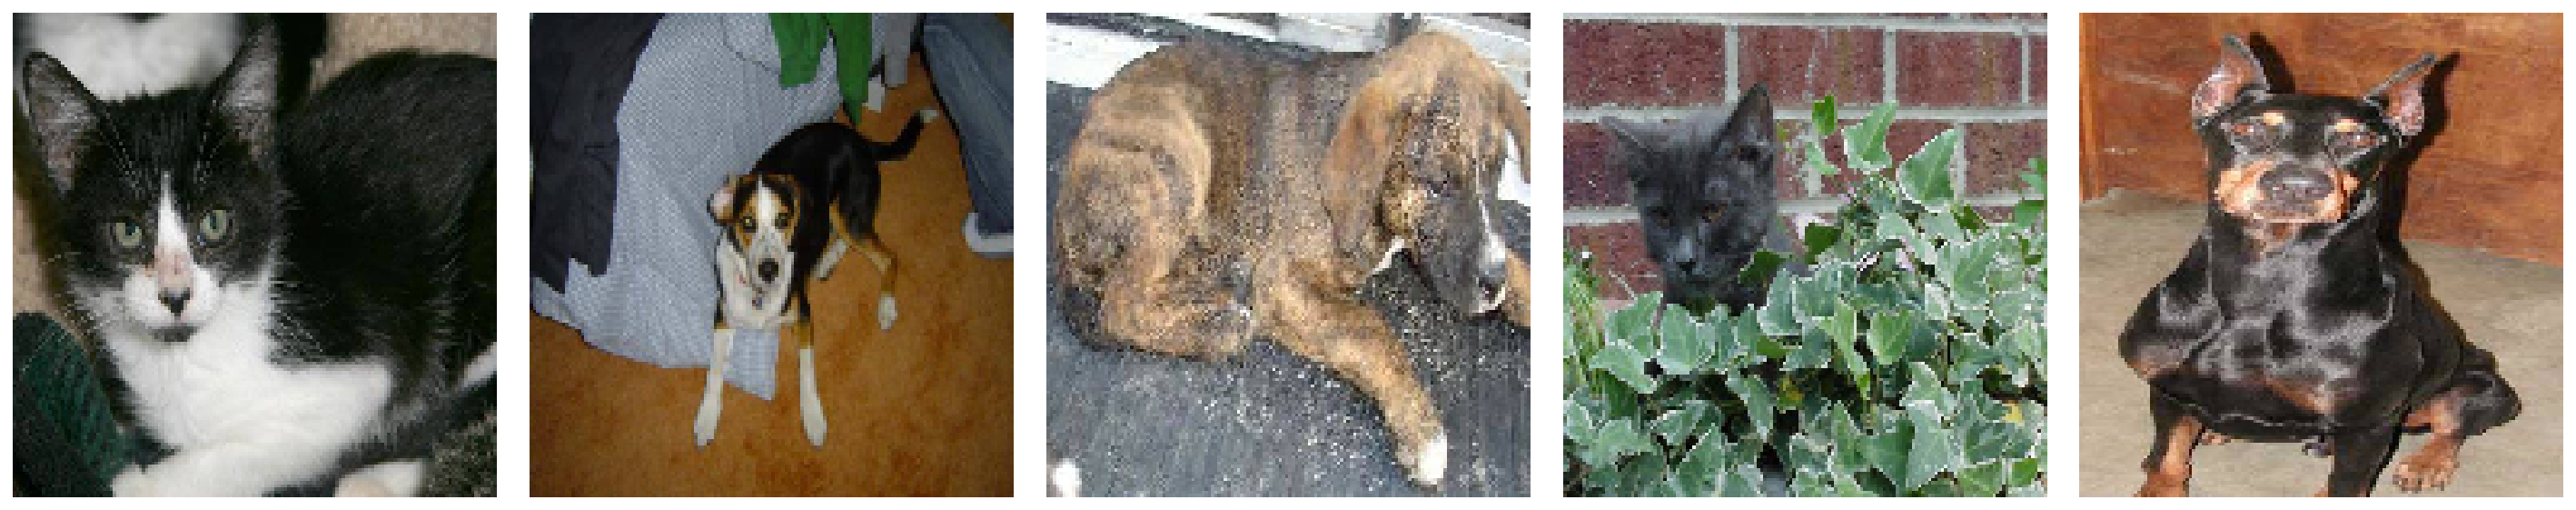

Found 2000 images belonging to 2 classes.


In [6]:
def plot_images(images_array):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_array, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images, sample_training_labels = next(train_data_gen)
plot_images(sample_training_images[:5])

Lets create a simple convolutional neural network model, with three convolutional layers followed by a max-pooling layer, where each $CONV$ layer (`Conv2D`) has a receptive field of size $3 \times 3$ i.e. $F=3$, and the zero padding automatically set so that the output spatial size is the same as the input spatial size. Each max-pooling layer $POOL$ (`MaxPooling2D`) without setting any parameters, has a default fitlers of size $2 \times 2$ applied with a stride of $2$ ($F=2, S=2$), which downsamples every depth slice in the input by $2$ along both width and height, discarding $75\%$ of the activations.

In [7]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [8]:
# Train the model with the generator
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 7 steps
Epoch 1/15
15/15 [==============================] - 15s 1s/step - loss: 0.7615 - accuracy: 0.4973 - val_loss: 0.6900 - val_accuracy: 0.4967
Epoch 2/15
15/15 [==============================] - 13s 844ms/step - loss: 0.6794 - accuracy: 0.5048 - val_loss: 0.6620 - val_accuracy: 0.6395
Epoch 3/15
15/15 [==============================] - 13s 839ms/step - loss: 0.6191 - accuracy: 0.6202 - val_loss: 0.6131 - val_accuracy: 0.6741
Epoch 4/15
15/15 [==============================] - 13s 842ms/step - loss: 0.5857 - accuracy: 0.6683 - val_loss: 0.5708 - val_accuracy: 0.6507
Epoch 5/15
15/15 [==============================] - 13s 850ms/step - loss: 0.5100 - accuracy: 0.7276 - val_loss: 0.5514 - val_accuracy: 0.7076
Epoch 6/15
15/15 [==============================] - 13s 839ms/step - loss: 0.4606 - accuracy: 0.7628 - val_loss: 0.6152 - val_accuracy: 0.7299
Epoch 7/15
15/15 [==============================] - 12

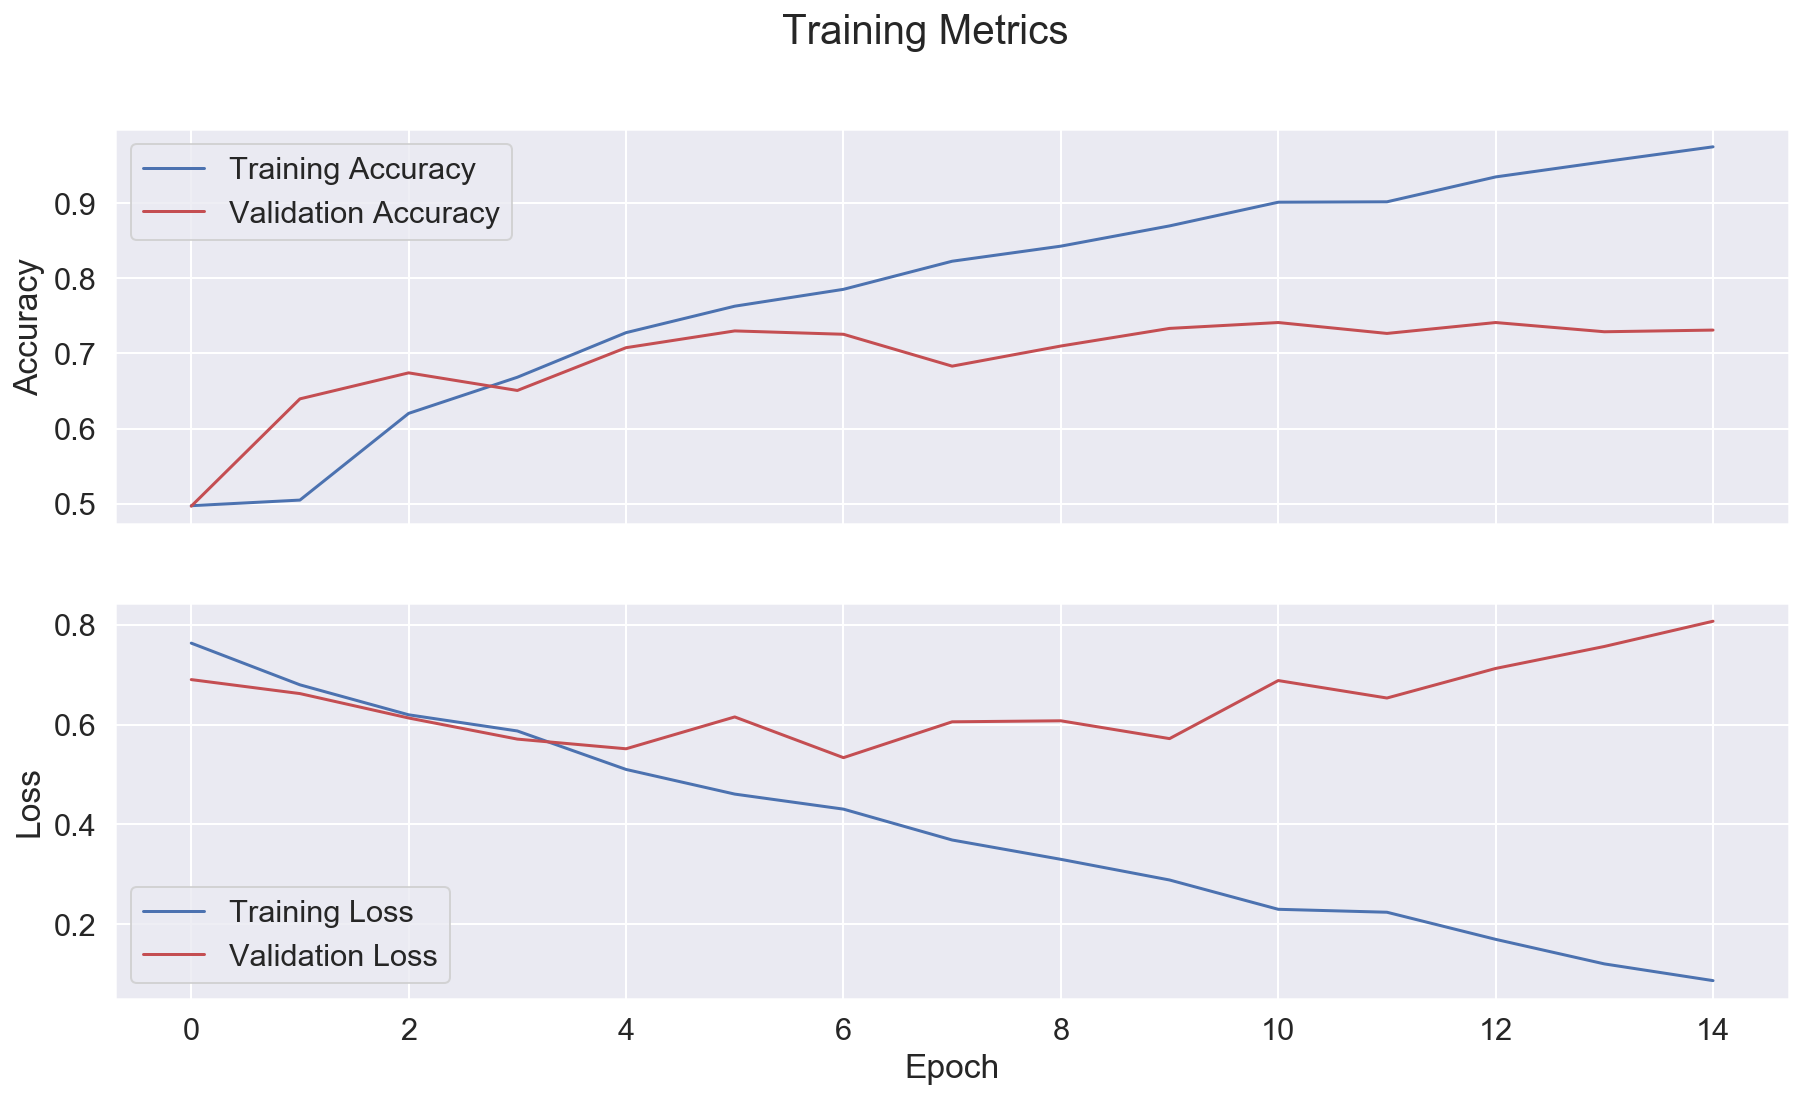

In [9]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
fig, axes = plt.subplots(2, sharex=True, figsize=(15, 8))
fig.suptitle('Training Metrics')

epochs_to_mean = 1

axes[0].set_ylabel("Accuracy")
axes[0].plot(history_df['accuracy'].rolling(epochs_to_mean).mean(), 'b')
axes[0].plot(history_df['val_accuracy'].rolling(epochs_to_mean).mean(), '-r')
axes[0].legend(['Training Accuracy', 'Validation Accuracy'])

axes[1].set_ylabel("Loss")
axes[1].plot(history_df['loss'].rolling(epochs_to_mean).mean(), 'b')
axes[1].plot(history_df['val_loss'].rolling(epochs_to_mean).mean(), '-r')
axes[1].legend(['Training Loss', 'Validation Loss'])
axes[1].set_xlabel("Epoch")

plt.show()

As we can see from the above graph our model has *overfit* the traing data, due to the divergence in the loss and training and validation accuracies.

Here the dominant reason our model has *overfit* is due to the small training dataset size, which invariably contains noise and our model is overfitting to that noise, we instead wish to create a model that can generalise better on new unseen examples.

We have previously covered multiple ways of overfitting, however the best way to prevent overfitting for our small training set is to increase it with data augmentation and adding dropout to our model.

# Data Augmentation

One way to generate more training samples from a small training dataset to avoid overfitting is to use *Data Augmentation*, where we generate more training data from existing traininig samples by augmenting the samples using random transformations that yield believable-looking images. Here the goal is for the model to never see the exact same picture twice during training. This helps create a model that can generalise better.

Some of the transformations available to use are:

### Horizontal flip

We can achieve this by passing the keyword argument `horizontal_flip=True` to the `ImageDataGenerator` class when we instantiate it. I.e.

Found 2000 images belonging to 2 classes.

Same image, horizontally flipped randomly


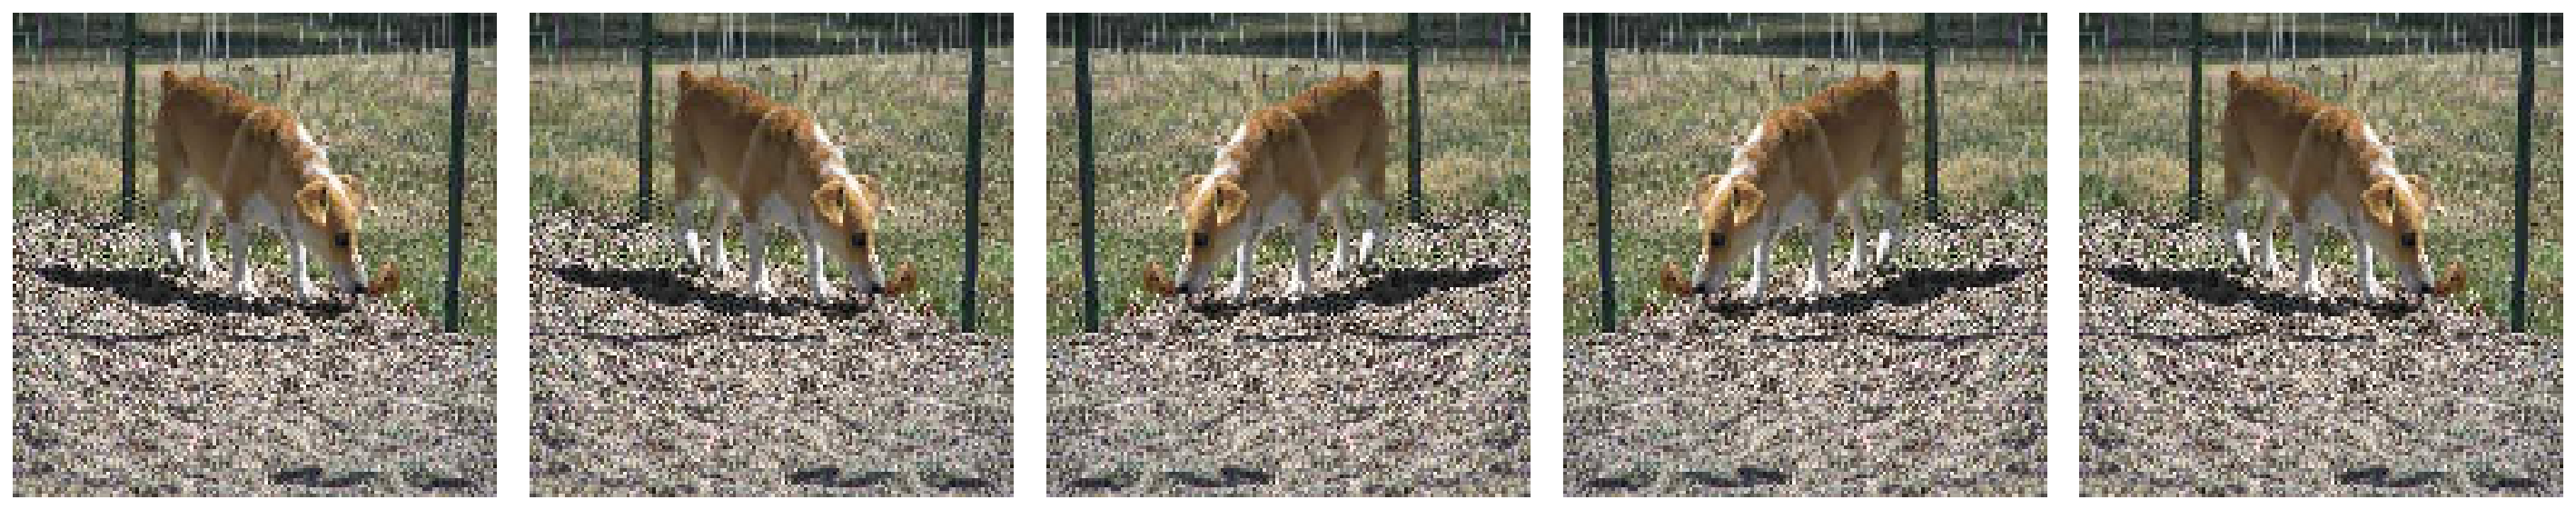

In [13]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
print('\nSame image, horizontally flipped randomly')
plot_images(augmented_images)

### Randomly rotate the image

We can achieve this by specifying the rotation range keyword argument `rotation_range=90` (e.g. to set a range of 90 degrees) to the `ImageDataGenerator` class when we instantiate it. I.e.

Found 2000 images belonging to 2 classes.

Same image, rotated different amounts


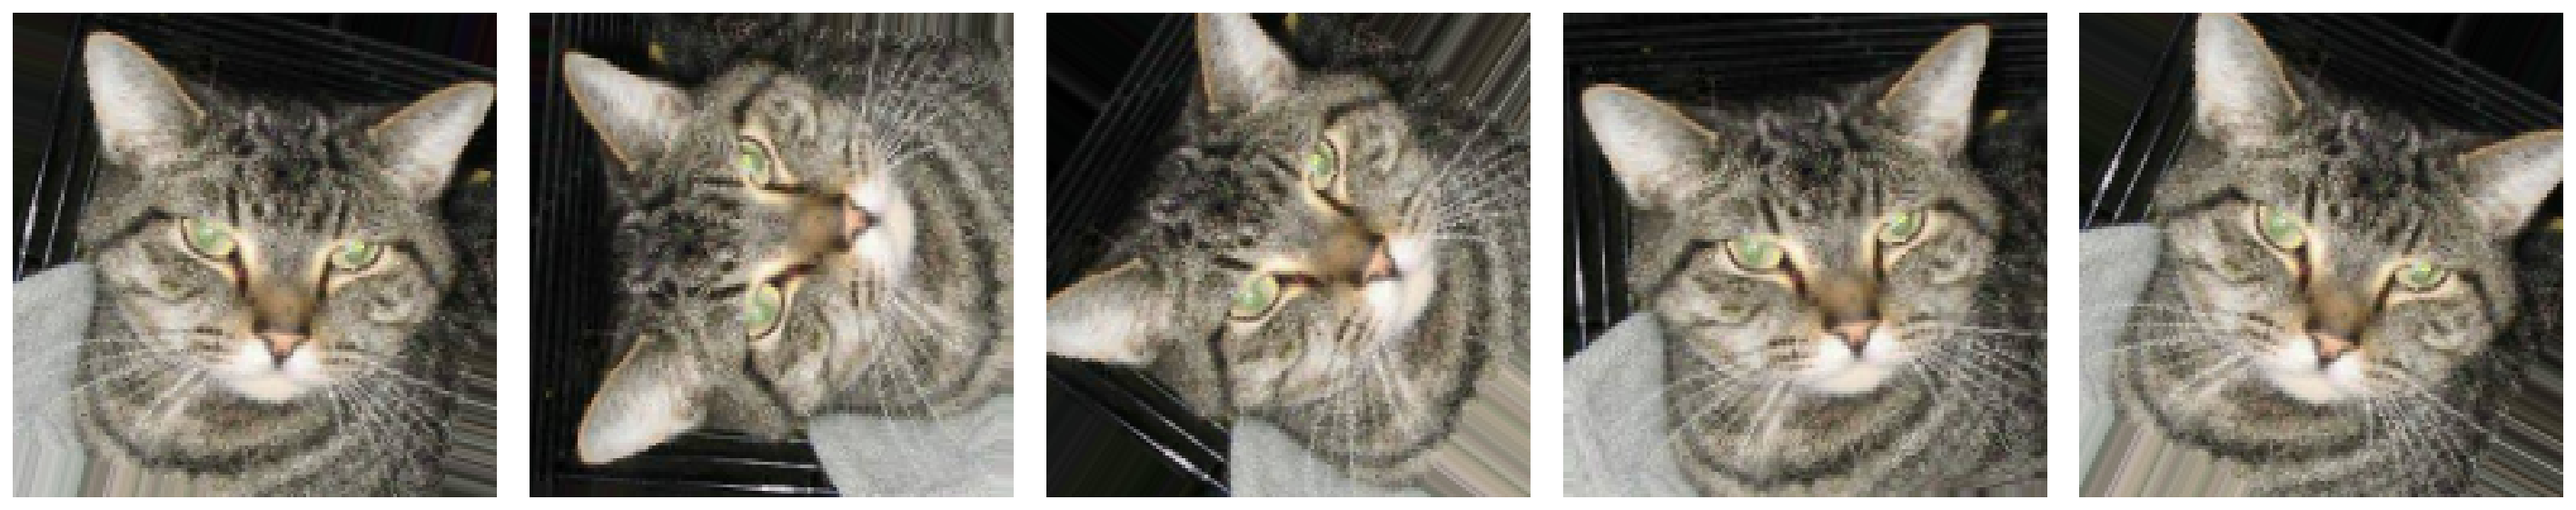

In [24]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=90)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
print('\nSame image, rotated different amounts')
plot_images(augmented_images)

### Randomly Zoom the image

We can achieve this by specifying the zoom range keyword argument `zoom_range=0.5` (e.g. to zoom images up to 50%) to the `ImageDataGenerator` class when we instantiate it. I.e.

Found 2000 images belonging to 2 classes.

Same image, zoomed different amounts


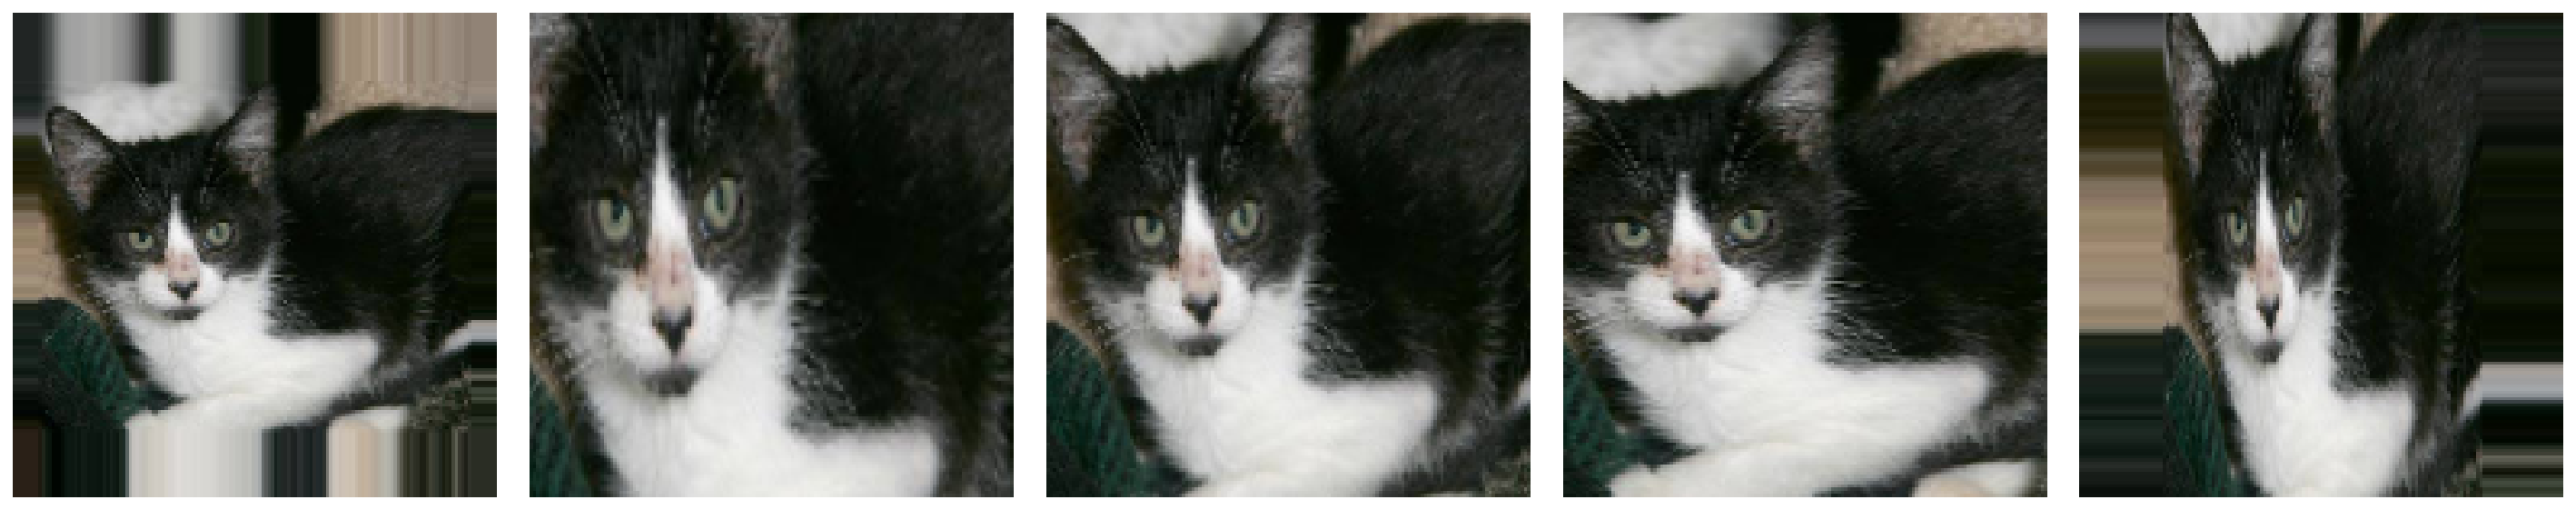

In [16]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
print('\nSame image, zoomed different amounts')
plot_images(augmented_images)

### Randomly change the brightness of the image

We can achieve this by specifying the brightness_range keyword argument `brightness_range=[0.2,1.0]` (e.g. to change the brightness to 20% to 100%) to the `ImageDataGenerator` class when we instantiate it. I.e.

Found 2000 images belonging to 2 classes.

Same image, different brightness levels


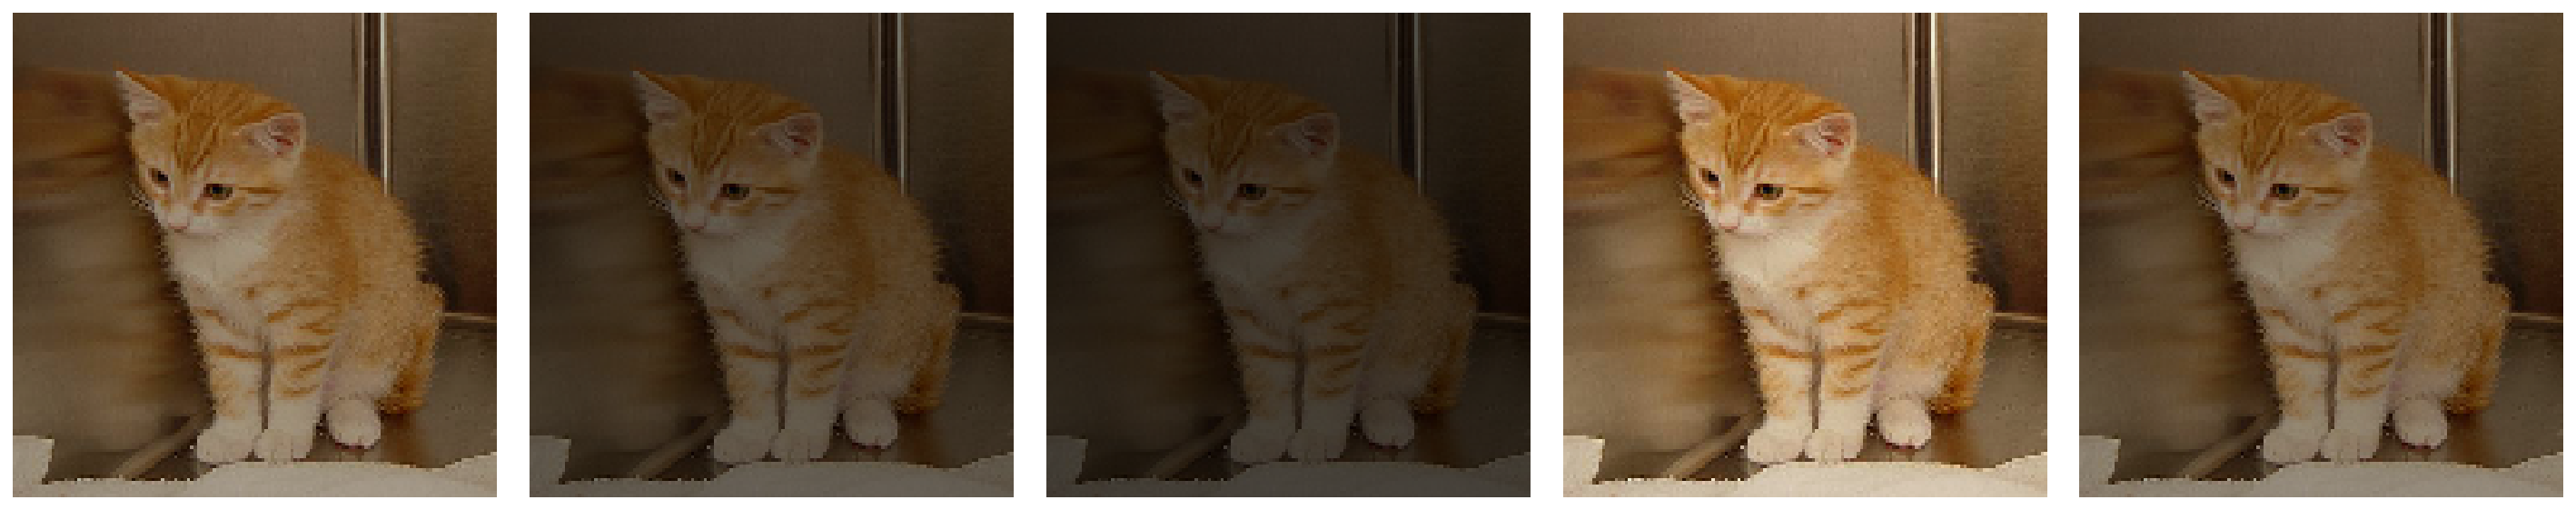

In [25]:
image_gen = ImageDataGenerator(rescale=1./255, brightness_range=[0.2,1.0])
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
print('\nSame image, different brightness levels')
plot_images(augmented_images)

### Randomly change the width shift of the image
We can achieve this by specifying the width_shift_range keyword argument `width_shift_range=0.5` (e.g. shift the width in the range of +50% and -50% of the image) to the `ImageDataGenerator` class when we instantiate it. I.e.

Found 2000 images belonging to 2 classes.

Same image, different width shifts


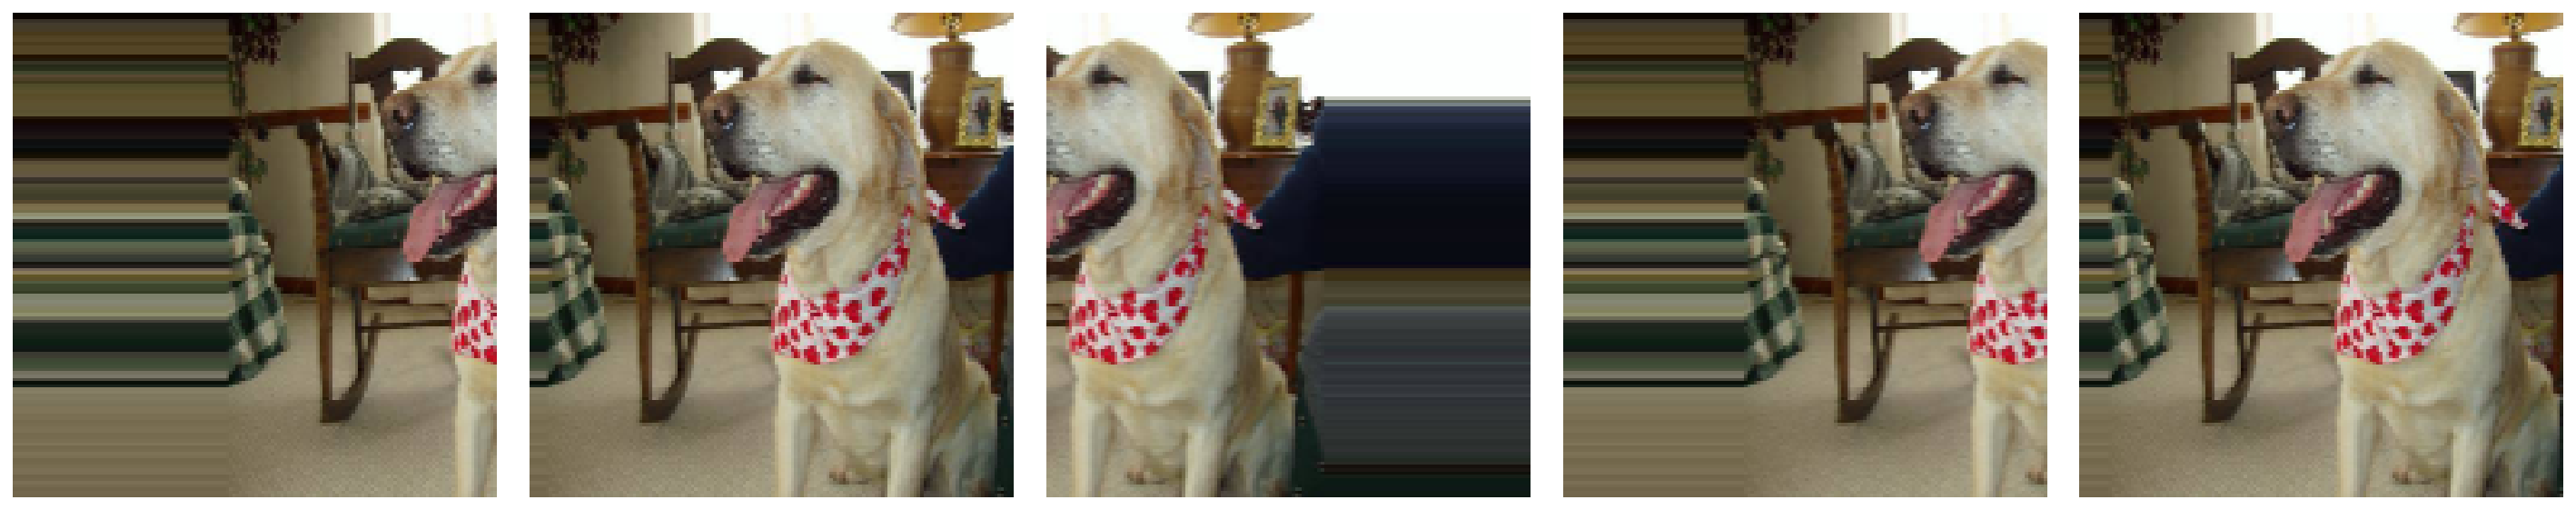

In [26]:
image_gen = ImageDataGenerator(rescale=1./255, width_shift_range=0.5)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
print('\nSame image, different width shifts')
plot_images(augmented_images)

### Randomly change the height shift of the image
We can achieve this by specifying the height_shift_range keyword argument `height_shift_range=0.5` (e.g. shift the height in the range of +50% and -50% of the image) to the `ImageDataGenerator` class when we instantiate it. I.e.

Found 2000 images belonging to 2 classes.

Same image, zoomed different amounts


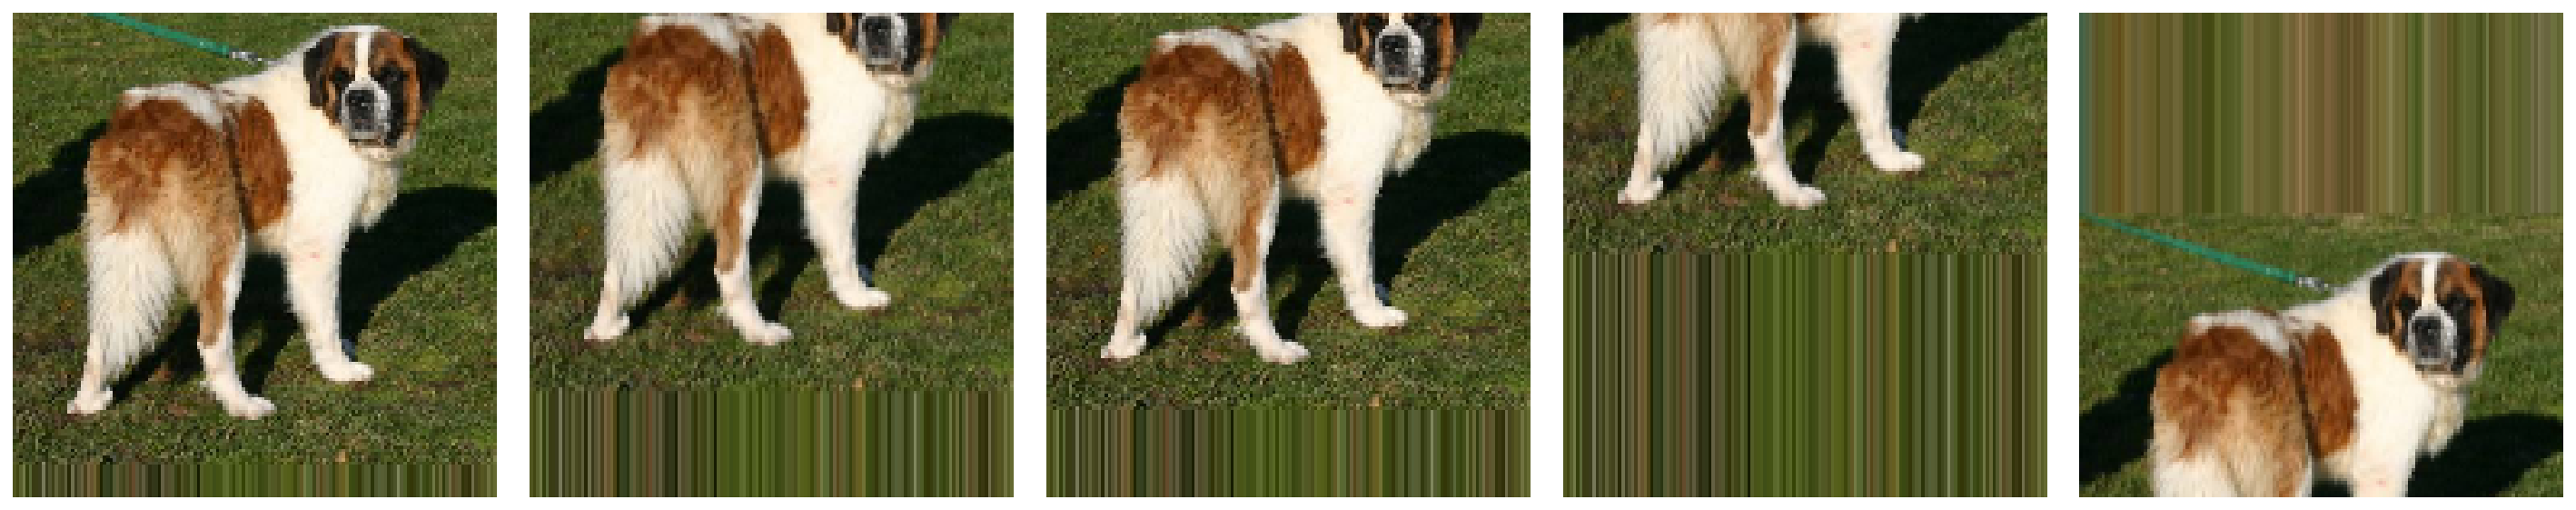

In [27]:
image_gen = ImageDataGenerator(rescale=1./255, height_shift_range=0.5)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
print('\nSame image, zoomed different amounts')
plot_images(augmented_images)

## Data Augmentation in Pratice

We generally only augment our training samples, and instead leave our validation dataset not augmented, and only re-scaled. I.e.

In [43]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


In [44]:
# Lets create out augmented dataset
image_gen = ImageDataGenerator(rescale=1./255,
                               height_shift_range=0.15,
                               width_shift_range=0.15,
                               zoom_range=0.5,
                               rotation_range=45,
                               horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 2000 images belonging to 2 classes.


## Image Classification with Augmentation & Dropout

We can also add dropout to reduce *overfitting* to the network. Each dropout layer is parameterised by the fractional number of outputs units to randomly drop from the applied layer (e.g. 0.2 would be drop $20\%$ of the output units) during training.

Here it is best pratice to apply dropout to the first and last max pool layers.

In [47]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
#     Dropout(0.1),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
#     Dropout(0.1),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [48]:
# Train the model with the generator
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 62 steps, validate for 31 steps
Epoch 1/15
62/62 [==============================] - 23s 371ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5020
Epoch 2/15
62/62 [==============================] - 29s 460ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 3/15
62/62 [==============================] - 24s 383ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5020
Epoch 4/15
62/62 [==============================] - 24s 380ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 5/15
 8/62 [==>...........................] - ETA: 18s - loss: 0.6931 - accuracy: 0.5000

KeyboardInterrupt: 